<a href="https://colab.research.google.com/github/salmonin-o3o/ESAA_study/blob/main/250307_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

핸즈온
# CH 04. 모델 훈련

머신러닝 모델과 훈련 알고리즘은 많은 일을 처리할 수 있다. 이때 어떻게 작동하는지 잘 이해하고 있으면 적절한 모델, 올바른 훈련 알고리즘, 작업에 맞는 좋은 하이퍼파라미터를 빠르게 찾을 수 있다.

따라서 가장 간단한 모델 중 하나인 선형 회귀부터 시작해서 더 자세히 알아보자.

**모델을 훈련시키는 방법**
- 직접 계산할 수 있는 공식을 사용하여 훈련 세트에 가장 잘 맞는 모델 파라미터를 해석적으로 구한다.
- 경사 하강법이라 불리는 반복적인 최적화 방식을 사용한다. (배치 경사 하강법, 미니배치 경사 하강법, 확률적 경사 하강법 등이 있다.)

그다음에는 비선형 데이터셋에 훈련시킬 수 있는 다항 회귀에 대해서도 알아보자. 과대 적합을 감소시킬 수 있는 규제 기법과 로지스틱 회귀, 소프트맥스 회귀를 살펴보자.

## 4.1 선형 회귀
모델을 훈련시킨다는 것은 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정하는 것이다. 따라서, 선형 회귀 모델에서는 RMSE를 최소화하는 theta를 찾아야 한다.

### 4.1.1 정규방정식
비용 함수를 최소화하는 theta값을 찾기 위한 해석적인 방법이 있다. 이를 정규방정식이라고 한다. 정규방정식을 테스트한다.

In [2]:
import numpy as np
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.rand(100,1)

In [4]:
X_b = np.c_[np.ones((100, 1)), X] # 모든 샘플에 x0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
theta_best

array([[4.52644294],
       [2.985642  ]])

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.52644294],
       [10.49772694]])

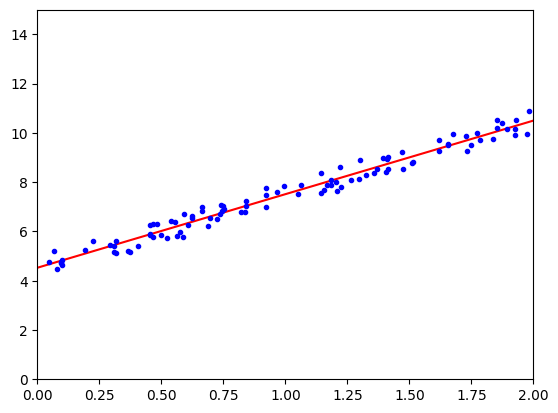

In [8]:
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [10]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.52644294]), array([[2.985642]]))

In [11]:
lin_reg.predict(X_new)

array([[ 4.52644294],
       [10.49772694]])

LinearRegression 클래스는 scipy.linalg.lstsq() 함수를 기반으로 한다.

In [12]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.52644294],
       [2.985642  ]])

이 함수는 유사역행렬 * y를 계산한다. 비슷하게, np.linalf.pinv() 함수를 이용해 유사역행렬을 직접 구할 수도 있다. 유사역행렬 자체는 특잇값 분해라 부르는 표준 행렬 분해 기법을 사용해 계산된다. 정규방정식을 계산하는 것보다 이 방식이 훨씬 효율적이다. 그리고 유사역행렬은 항상 구할 수 있다.

In [13]:
np.linalg.pinv(X_b).dot(y)

array([[4.52644294],
       [2.985642  ]])

### 4.1.2 게산 복잡도
정규방정식에서 역행렬을 계산하는 계산 복잡도는 일반적으로 O(n^2.4)에서 O(n^3)사이이다. 다시 말해 특성 수가 두 배로 늘어나면 계산 시간이 대략 5.
에서 8배로 증가한다.

또한 학습된 선형 회귀 모델은 예측이 매우 빠르다. 예측 계산 복잡도는 샘플 수와 특성 수에 선형적이다. 특성이 매우 많고 훈련 샘플이 너무 많을 때에 적합한 방법은 따로 있다.

## 4.2 경사 하강법
theta를 임의의 값으로 시작해서(무작위 초기화) 한 번에 조금씩 비용 함수가 감소되는 방향으로 진행하여 알고리즘이 최솟값에 수렴할 때까지 점진적으로 향상시킨다.

경사 하걍법에서 중요한 파라키터는 스텝의 크기로, 학습률(learning rate)하이퍼파라미터로 결정된다. 학습률이 너무 작으면 시간이 오래 걸린다. 학습률이 너무 크면 알고리즘을 더 큰 값으로 발산하게 만들어 적절한 해법을 찾지 못하게 된다.

경사 하강법은 전역 최솟값보다 덜 좋은 지역 최솟값에 수렴할 수도 있다.

다행히 선형 회귀를 위한 MSE 비용함수는 볼록 함수이기 때문에 경사 하강법을 통해 전역 최솟값에 가깝게 접근할 수 있다.

대신, 경사 하강법을 사용할 떄는 반드시 모든 특성이 같은 스케일을 갖도록 만들어야한다. (사이킷런의 StandardScaler 사용)

모델 훈련이 비용 함수를 최소화하는 모델 파라미터의 조합을 찾는 일이다. 이것을 모델의 파라미터 공간에서 찾는다고 말하며, 파라미터가 많을 수록 어렵다.

### 4.2.1 배치 경사 하강법
경사 하강법을 구현하려면 모델 파라미터가 조금 변경될 때 비용 함수가 얼마나 바뀌는지 계산해야한다. 이것을 편도 함수라고 한다. 비용함수의 그래디언트 벡터를 매 경사 하강법 스텝에서 전체 훈련 세트에 대해 계산한다면 이 알고리즘을 배치 경사 하강법이라고 한다. 따라서, 매우 큰 훈련 세트에서는 아주 느리다.

In [14]:
eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients

In [15]:
theta

array([[4.52644294],
       [2.985642  ]])

적절한 학습률을 찾으려면 그리드 탐색을 사용하자. 하지만 그리드 탐색에서 수렴하는 데 너무 오래 걸리는 모델을 막기 위해 반복 횟수를 제한해야한다.

반복 횟수를 정하는 간단한 해결책은 반복 횟수를 아주 크게 지정하고 그레이디언트 벡터가 아주 작아지면, 즉 벡터의 노름이 어떤 값(허용 오차)보다 작아지면 경사 하강법이 회솟값에 도달한 것이므로 알고리즘을 중단하는 것이다.

### 4.2.2 확률적 경사 하강법
확률적 경사 하강법은 매 스텝에서 한 개의 샘플을 무작위로 서낵하고 그 하나의 샘플에 대한 그레이디언트를 계산한다. 따라서 알고리즘이 확실히 훨씬 빠르다.

반면에 확률적이기 때문에 배치 경사 하강법보다 불안정하다.

무작위성은 지역 최솟값에서 탈출시켜줘서 좋지만 알고리즘을 전역 최솟값에 다다르지 못하게 한다.(근접하겠지만 최적치는 아님) 따라서 학습률을 점진적으로 감소시키는 방법으로 해결할 수 있다. 매 반복에서 학습률을 결정하는 함수를 학습 스케쥴이라고 부른다.

In [16]:
n_epochs = 50
t0, t1 = 5, 50 # 학습 스케쥴 하이퍼파라미터

def learning_schedule(t):
  return t0 / (t + t1)

theta = np.random.randn(2,1) # 무작위 초기화

for epoch in range(n_epochs):
  for i in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(epoch * m + i)
    theta = theta - eta * gradients

In [17]:
theta

array([[4.52392999],
       [2.97788279]])

사이킷런에서 SGD 방식으로 선형 회귀를 사용하려면 기본값으로 제곱 오차 비용 함수를 최적화하는 SGDRegressor 클래스를 사용한다.

In [18]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [19]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.48106485]), array([2.99111435]))

### 4.2.3 미니배치 경사 하강법
미니 배치라 부르는 임의의 작은 샘플 세트에 대해 드레이디언트를 계산한다. 행렬 연산에 최적화된 하드웨어, 특히 GPU를 사용해서 얻는 성능 향상이다.

미니 배치를 어느정도 크게하면 SGD보다 최솟값에 더 가까이 도달하게 될 것이지만 지역 최솟값에서 빠져나오기는 더 힘들 것이다.

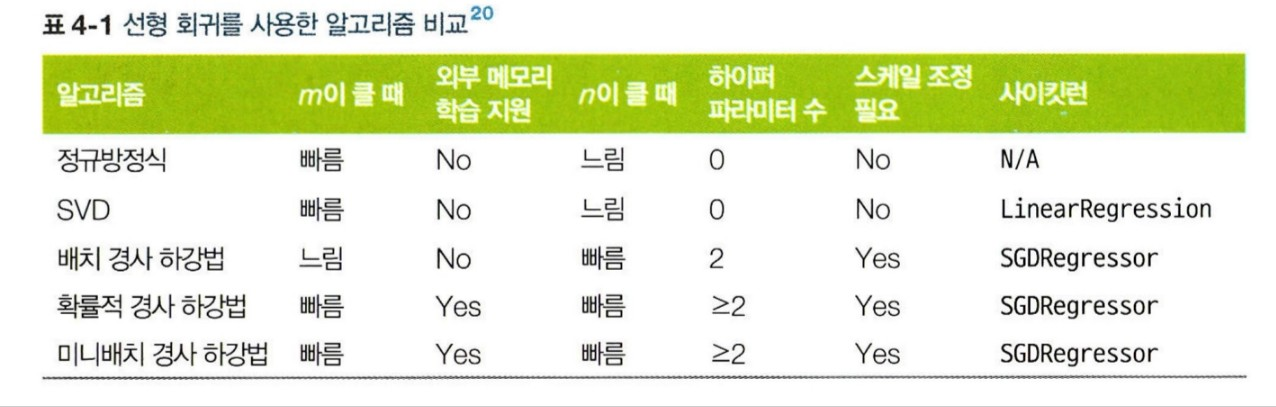

## 4.3 다항 회귀
비선형 데이터를 학습하는 데 선형 모델을 사용할 수 있다. 다항 회귀라고 한다.

In [20]:
m = 100
X = 6 * np.random.randn(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [23]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-13.1092705])

In [24]:
X_poly[0]

array([-13.1092705 , 171.85297311])

In [25]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.17374242]), array([[0.99847918, 0.49783947]]))

PolynomialFeatures가 주어진 차수까지 특성 간의 모든 교차항을 추가한다.

## 4.4 학습 곡선
고차 다항 회귀를 적용하면 보통의 선형의 회귀에서보다 훨씬 더 훈련 데이터에 잘 맞추려 할 것이다. 그러면 과대적합이 될 수 있다. 반면에 선형 모델은 과소적합이 될 수 있다.

교차 검증을 사용할 수 있다.

또 다른 방법은 학습 곡선을 살펴보는 것이다. 이 그래프는 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기의 함수로 나타낸다.

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
      model.fit(X_train[:m], y_train[:m])
      y_train_predict = model.predict(X_train[:m])
      y_val_predict = model.predict(X_val)
      train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
      val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

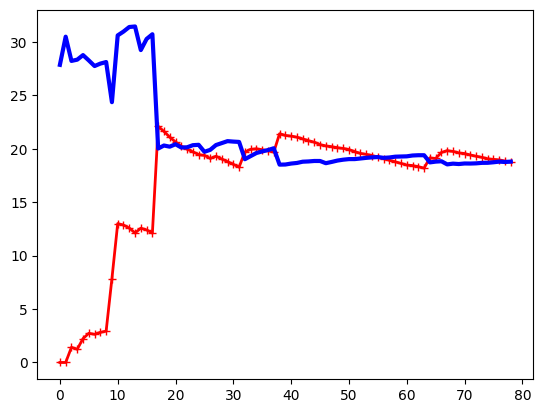

In [27]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

과소적합 모델의 전형적인 모습은 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해 있는 모양이다.

+) 더 복잡한 모델을 사용하거나 더 나은 특성을 선택해서 해결.

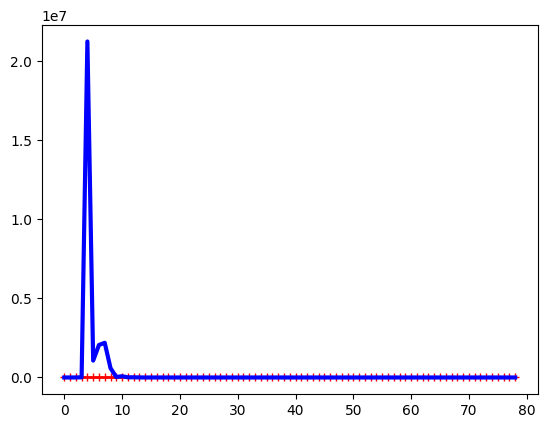

In [28]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)

과대 적합 모델의 특징
- 훈련 데ㅣ터의 오차가 선형 회귀 모델보다 훨씬 낮다.
- 두 곡선 사이에 공간이 있다.

+) 더 많은 훈련 데이터를 추가

#### 편향/분산 트레이드오프
- 편향: 일반화 오차 중에서 편향은 잘못된 가정으로 인한 것이다. ex) 데이터가 실제로는 2차인데 선형으로 가정. 편향이 큰 모델은 훈련 데이터에 과소적합되기 쉽다.

- 분산: 훈련 데이터에 있는 작은 변동에 모델이 과도하게 민감하기 때문에 나타남. 자유도가 높은 모델(예를 들어 고차 다항 회귀 모델)이 높은 분산을 가지기 쉬워 훈련 데이터에 과대적합되는 경향이 있다.

- 줄일 수 없는 오차: 데이터 자체에 있는 잡음.

모델의 복잡도가 커짐-> 분산이 늘어나고 편향이 줄어든다.

모델의 복잡도가 줄어듦-> 편향이 커지고 분산이 작아진다.
= 트레이드오프